In [1]:
import torch
from torch import nn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from typing import List, Tuple, Dict, Callable

import time

In [2]:
from IPython.display import display as d

In [3]:
from omegaconf import OmegaConf

## Some solutions of PDE (partial differential equations)

In [4]:
N = 10_000

x: torch.Tensor = torch.empty(size=(N, ))
x.uniform_(0, 1)


y: torch.Tensor = torch.empty(size=(N, ))
y.uniform_(0, 1)
# t: torch.Tensor = torch.empty(size=(batch_size, 1))
# t.uniform_(0, 10)

u: List # u = u(x, t)

In [5]:
u = torch.sin(torch.pi * x) * torch.sin(torch.pi * y)

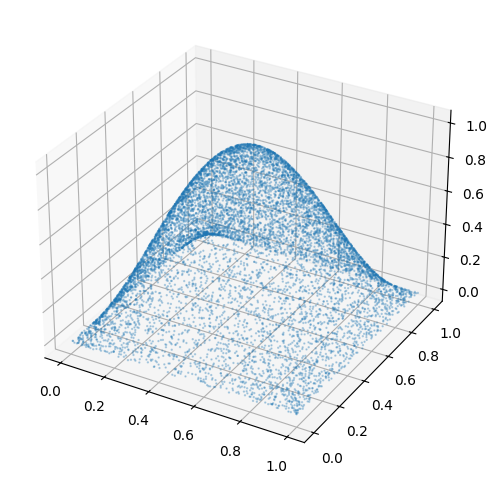

In [6]:
ax = plt.figure(figsize=(6, 6)).add_subplot(projection="3d")

ax.scatter(x, y, u, s=0.5, alpha=0.3)

plt.show()

In [7]:
plt.close("all")

## PINN for solving PDE

In [4]:
from src.data.components.dataset import SpatialTemporalDomain
from src.data.components.collate import BaseCollator, ModelInput, SingleForwardState, Coords, ModelBatch

In [5]:
class SpatialXTemporalDomain2D(torch.utils.data.Dataset):
    def __init__(
            self, 
            n_samples: int = 10_000, 
            seq_len: int = 128,
            xmin: float = 0.0, 
            xmax: float = 1.0, 
            tmin: float = 0.0, 
            tmax: float = 1.0,
            noise: float = 0.0
        ) -> None:

        self.data_size = n_samples

        self.nrof_bins = self.data_size // seq_len

        _X: torch.Tensor = torch.empty(size=(n_samples, 1))
        _X.uniform_(xmin, xmax)

        _X = torch.sort(_X.ravel()).values
        
        self.X = torch.stack(
            [
                _X[bin * seq_len:bin * seq_len + seq_len][torch.randperm(seq_len)] for bin in range(self.nrof_bins)
            ]
        )[torch.randperm(self.nrof_bins)]

        self.X += noise * torch.randn(size=self.X.size())


        _T: torch.Tensor = torch.empty(size=(n_samples, 1))
        _T.uniform_(tmin, tmax)

        _T = torch.sort(_T.ravel()).values
        
        self.T = torch.stack(
            [
                _T[bin * seq_len:bin * seq_len + seq_len][torch.randperm(seq_len)] for bin in range(self.nrof_bins)
            ]
        )[torch.randperm(self.nrof_bins)]

        self.T += noise * torch.randn(size=self.T.size())


    def __getitem__(self, idx: int):
        return {
            "coords": {
                "x": self.X[idx]
            },
            "time": self.T[idx]
        }

    def __len__(self):
        return self.nrof_bins

In [93]:
dataset = SpatialXTemporalDomain2D(n_samples=100_000, seq_len=128, xmin=-10, xmax=10, tmin=0, tmax=20)

In [7]:
dataset = SpatialTemporalDomain(coords_limits={"x": [0, 1]}, time_limits=[0, 1], n_samples=10_000)

In [10]:
train, valid = torch.utils.data.random_split(
    dataset, [0.9, 0.1]
)

In [11]:
BATCH_SIZE = 64

In [12]:
class BaseCollator2D:
    def __init__(self, with_coords: bool = True, with_time: bool = True):
        self.with_coords = with_coords
        self.with_time = with_time

    def __call__(self, batch: List[Dict]) -> ModelBatch:
        if self.with_coords:
            coords_keys = ["x", "y", "z"]

            coords = dict().fromkeys(coords_keys)

            for key in batch[0]["coords"].keys():
                coords[key] = torch.stack([item["coords"][key] for item in batch], dim=0).unsqueeze(dim=-1)

                coords[key].requires_grad_(True)
        else:
            coords = None

        if self.with_time:
            time = torch.stack([item["time"] for item in batch], dim=0).unsqueeze(dim=-1)

            time.requires_grad_(True)
        else:
            time = None

        return ModelBatch(
            coords=Coords(**coords), 
            time=time
        )

In [13]:
train_loader = torch.utils.data.DataLoader(
    dataset=train, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    collate_fn=BaseCollator()
)
valid_loader = torch.utils.data.DataLoader(
    dataset=valid, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    collate_fn=BaseCollator()
)

In [14]:
sample = next(iter(train_loader))

In [60]:
x = torch.randn((4, 1), requires_grad=True)
y = torch.randn((4, 1), requires_grad=True)

In [64]:
d(torch.concatenate(list({"x": x, "y": y}.values()), dim=-1).sum(dim=-1, keepdim=True))

tensor([[-0.1332],
        [-2.0023],
        [-1.3780],
        [-2.8331]], grad_fn=<SumBackward1>)

In [32]:
from src.models.pde_lit_model_xt import PDELitModule
from src.models.components.pde_nn import PDESimpleNN
from src.models.components.linear_blocks.linear_down_up_block import LinearDownUpBlock

In [33]:
class PDEBurgerCondition(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inputs: ModelInput) -> torch.Tensor:
        return torch.zeros(size=inputs.time.size())


class PDEOtherCondition(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inputs: ModelInput) -> torch.Tensor:
        return torch.zeros(size=inputs.time.size())


class InitialConditions(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, coords: Coords) -> torch.Tensor:
        # return torch.zeros(coords.x.size())
        return torch.exp(-torch.square(coords.x) / 2)


class BoundaryXYZConditions(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inputs: ModelInput) -> torch.Tensor:
        return torch.zeros(size=inputs.time.size())

In [34]:
class MainEncoderLayer(nn.Module):
    def __init__(
            self,
            embedding_sequence_dim: int = 8,
            embedding_features_dim: int = 0,
            dropout_inputs: float = 0.3,
            num_coords: bool = False,
            with_time: bool = False
        ) -> None:
        super(MainEncoderLayer, self).__init__()

        self.dropout = nn.Dropout(p=dropout_inputs)

        self.branched_linear_block_xyz = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(1, embedding_sequence_dim),
                    nn.Tanh()
                ) for _ in range(num_coords)
            ]
        )

        self.linear_block_t = nn.Sequential(
            nn.Linear(1, embedding_sequence_dim),
            nn.Tanh()
        ) if with_time else None

        if embedding_features_dim > 0:
            in_features = num_coords + 1 if with_time else num_coords

            self.out_linear_block = nn.Linear(
                in_features, embedding_features_dim
            )
        else:
            self.out_linear_block = nn.Identity()


    def forward(self, inputs: ModelInput) -> SingleForwardState:

        coords = [coord for coord in inputs.coords if coord is not None]

        coords_emb = torch.concatenate(
            [
                head(coord) for coord, head in zip(coords, self.branched_linear_block_xyz)
            ], dim=1
        )

        time_emb = self.linear_block_t(inputs.time)

        # emb = torch.stack([coords_emb, time_emb], dim=-1) # (batch_size, emb_dim, num_coords + 1)
        emb = torch.concatenate([coords_emb, time_emb], dim=-1)

        x = self.dropout(emb)
        # x = self.out_linear_block(x)

        return SingleForwardState(
            sequences=x
        )

In [35]:
EMB_DIM = 8

In [36]:
a = MainEncoderLayer(
    embedding_sequence_dim=EMB_DIM, 
    dropout_inputs=0.3, 
    num_coords=1, 
    with_time=True
)

In [37]:
d(a(sample).sequences.size())

torch.Size([64, 16])

In [38]:
emb_dim = 8

model = PDESimpleNN(
    layers=[
        MainEncoderLayer(
            embedding_sequence_dim=emb_dim, 
            embedding_features_dim=0, 
            dropout_inputs=0.1, 
            num_coords=1, 
            with_time=True
        ),
        LinearDownUpBlock(
            in_features=emb_dim * 2,
            out_features=1,
            down=True,
            num_layers=2,
            dropout_rate=0.0,
            activation_type="tanh",
            use_batch_norm=False
        )
    ]
)

In [39]:
model.layers

Sequential(
  (0): MainEncoderLayer(
    (dropout): Dropout(p=0.1, inplace=False)
    (branched_linear_block_xyz): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=1, out_features=8, bias=True)
        (1): Tanh()
      )
    )
    (linear_block_t): Sequential(
      (0): Linear(in_features=1, out_features=8, bias=True)
      (1): Tanh()
    )
    (out_linear_block): Identity()
  )
  (1): LinearDownUpBlock(
    (dropout): Dropout(p=0.0, inplace=False)
    (linear_block): Sequential(
      (0): Sequential(
        (0): Linear(in_features=16, out_features=8, bias=True)
        (1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (2): Tanh()
      )
      (1): Sequential(
        (0): Linear(in_features=8, out_features=4, bias=True)
        (1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
        (2): Tanh()
      )
    )
    (out_block): Linear(in_features=4, out_features=1, bias=True)
    (cls_layers): Sequential(
      (0): Dropout(p=0.0, inplace=F

In [40]:
from functools import partial

In [41]:
lit_module = PDELitModule(
    net=model,
    train_batch_size=BATCH_SIZE,
    val_batch_size=BATCH_SIZE,
    conditional_loss="val/loss",
    condition_names=["pdec", "ic"],
    num_coords=1,
    conditions={
        "pdec": PDEBurgerCondition(),
        "ic": [InitialConditions()],
        "other_pdec": [PDEOtherCondition()],
        "bc": []
    },
    bc_limits=[0.0, 1.0],
    optimizer=partial(torch.optim.Adam, lr=1e-3, weight_decay=1e-4)
)

/home/danil/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


In [46]:
print(lit_module.derivative(nn.Sequential(nn.Linear(1, 8), nn.Linear(8, 1))(sample.coords.x), sample.coords.x, 2))

[tensor([[-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0.3766],
        [-0

In [79]:
d([lit_module.hparams])

"alpha":            1.0
"bc_limits":        [0.0, 1.0]
"beta":             1.0
"compile":          False
"condition_names":  ['pdec', 'ic', 'bc_lower', 'bc_upper']
"conditional_loss": val/loss
"conditions":       {'pdec': PDEBurgerCondition(), 'ic': [InitialConditions()], 'other_pdec': [PDEOtherCondition()], 'bc': []}
"net":              PDESimpleNN(
  (layers): Sequential(
    (0): MainEncoderLayer(
      (dropout): Dropout(p=0.1, inplace=False)
      (branched_linear_block_xyz): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=1, out_features=8, bias=True)
          (1): Tanh()
        )
      )
      (linear_block_t): Sequential(
        (0): Linear(in_features=1, out_features=8, bias=True)
        (1): Tanh()
      )
      (out_linear_block): Identity()
    )
    (1): LinearDownUpBlock(
      (dropout): Dropout(p=0.0, inplace=False)
      (linear_block): Sequential(
        (0): Sequential(
          (0): Linear(in_features=16, out_features=8, bias=True)
     

In [51]:
class Trainer:
    def __init__(
            self, 
            net: nn.Module, 
            train_dataloader: torch.utils.data.DataLoader, 
            valid_dataloader: torch.utils.data.DataLoader, 
        ) -> None:

        self.net = net

        self.train_data = train_dataloader
        self.valid_data = valid_dataloader

        self.train_results = list()
        self.valid_results = list()

        self.optimizer = self.net.hparams.optimizer

    def valid(self):
        n_total_steps = len(self.train_data)

        # with torch.no_grad():

        for step, inputs in enumerate(self.valid_data):

            loss, branched_loss, _, _ = self.net.model_step(inputs)

            self.valid_results.append(
                [
                    self.epoch * n_total_steps + step, 
                    loss.item(),
                    *[loss_item.item() for loss_item in branched_loss.values()]
                ]
            )


    def fit(self, epochs: int = 3, show_step: int = 100):
        n_total_steps = len(self.train_data)

        for epoch in range(epochs):
            epoch_start_time = time.time()

            self.epoch = epoch
            
            print('Epoch %s/%s' % (epoch + 1, epochs))

            for step, inputs in enumerate(self.train_data):
                self.optimizer.zero_grad(set_to_none=True)

                loss, branched_loss, _, _ = self.net.model_step(inputs)

                loss.backward()
                self.optimizer.step()

                self.train_results.append(
                    [
                        self.epoch * n_total_steps + step, 
                        loss.item(),
                        *[loss_item.item() for loss_item in branched_loss.values()]
                    ]
                )

                if (step + 1) % show_step == 0:
                    print(
                        f"Step [{step + 1}/{n_total_steps}] | Time: {time.time() - epoch_start_time:.2f}s |  "
                        f"Loss sum: {loss.item():.4f} | Loss pde: {branched_loss['pdec'].item():.4f} | "
                        f"Loss ic: {branched_loss['ic'].item():.4f}"
                        # f"Loss bc lower: {branched_loss['bc_lower'].item():.4f} | Loss bc upper: {branched_loss['bc_upper'].item():.4f}"
                    )

            self.valid()
            print(
                f"{'-' * 80}\n VALID "
                f"Loss sum: {self.valid_results[-1][1]:.4f}\n"
                f"{'-' * 80}"
            )


        # self.train_writer = pd.DataFrame(self.train_results, columns=["step", "loss", "loss_pde", "loss_ic", "loss_bc_lower", "loss_bc_upper"])
        # self.valid_writer = pd.DataFrame(self.valid_results, columns=["step", "loss", "loss_pde", "loss_ic", "loss_bc_lower", "loss_bc_upper"])
        print('\nDone.')


    def __repr__(self):
        return f'''[INFO]\n{"-" * 60}\ndata: {self.data} \n{"-" * 60} \nmodel: {self.model} \n{"-" * 60} \noptimizer: {self.optimizer} \n{"-" * 60}'''

In [64]:
train_model = Trainer(
    net=lit_module, 
    train_dataloader=train_loader, 
    valid_dataloader=valid_loader
)

In [53]:
train_model.fit(epochs=3, show_step=200)

Epoch 1/3
Step [200/1407] | Time: 3.22s |  Loss sum: 0.0143 | Loss pde: 0.0015 | Loss ic: 0.0128
Step [400/1407] | Time: 6.53s |  Loss sum: 0.0168 | Loss pde: 0.0012 | Loss ic: 0.0156
Step [600/1407] | Time: 9.71s |  Loss sum: 0.0135 | Loss pde: 0.0013 | Loss ic: 0.0122
Step [800/1407] | Time: 13.04s |  Loss sum: 0.0141 | Loss pde: 0.0009 | Loss ic: 0.0132
Step [1000/1407] | Time: 16.38s |  Loss sum: 0.0162 | Loss pde: 0.0008 | Loss ic: 0.0154
Step [1200/1407] | Time: 19.54s |  Loss sum: 0.0178 | Loss pde: 0.0016 | Loss ic: 0.0162
Step [1400/1407] | Time: 22.87s |  Loss sum: 0.0155 | Loss pde: 0.0008 | Loss ic: 0.0147
--------------------------------------------------------------------------------
 VALID Loss sum: 0.0155
--------------------------------------------------------------------------------
Epoch 2/3
Step [200/1407] | Time: 3.22s |  Loss sum: 0.0132 | Loss pde: 0.0015 | Loss ic: 0.0117
Step [400/1407] | Time: 6.42s |  Loss sum: 0.0297 | Loss pde: 0.0187 | Loss ic: 0.0110
Step

# Pretrained Model

In [4]:
from src.models.pde_lit_model_xt import PDELitModule
from IPython.display import display as d

import torch
from torch import nn

In [5]:
class PretrainedModel(nn.Module):
    def __init__(self, ckpt_path: str):
        super().__init__()
        
        self.net = PDELitModule.load_from_checkpoint(ckpt_path)
        self.net.eval()
        self.net.freeze()

    def forward(self, inputs):
        return self.net(inputs)

In [6]:
train_model = PretrainedModel("logs/train/runs/2024-06-30_01-14-50/checkpoints/epoch_003.ckpt")

/home/danil/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


In [7]:
d(dict(train_model.net.named_parameters()))

{'net.layers.0.branched_linear_block_xyz.0.0.weight': Parameter containing:
 tensor([[ 0.1764],
         [-0.3794],
         [-0.1219],
         [ 0.4602],
         [ 0.5292],
         [-0.3239],
         [ 0.8245],
         [ 0.6713],
         [-0.8594],
         [-0.5439],
         [ 0.7606],
         [ 0.4098],
         [ 0.8412],
         [ 0.4457],
         [ 0.7347],
         [ 0.5328]]),
 'net.layers.0.branched_linear_block_xyz.0.0.bias': Parameter containing:
 tensor([ 0.5354, -0.4565, -0.9675, -0.3232,  0.5181, -0.3618, -0.8215,  0.6261,
         -0.4152, -0.0565, -0.8620, -0.1515,  0.0588,  0.4564, -0.6679, -0.9816]),
 'net.layers.0.branched_linear_block_xyz.1.0.weight': Parameter containing:
 tensor([[-0.1796],
         [ 0.7498],
         [ 0.4792],
         [-0.1688],
         [-0.3612],
         [ 0.3114],
         [-0.3103],
         [ 0.4790],
         [ 0.0401],
         [ 0.3434],
         [-0.4462],
         [-0.1620],
         [-0.6453],
         [-0.2586],
        

# Visualize results

In [8]:
from src.data.components.dataset import SpatialTemporalDomain
from src.data.components.collate import ModelInput, Coords

from typing import List

import matplotlib.pyplot as plt

In [11]:
dataset = SpatialTemporalDomain(coords_limits={"x": [-10, 10], "y": [-0.1, 0.1]}, time_limits=[0, 5], n_samples=20_000)

x = dataset.coords["x"]
y = dataset.coords["y"]
t = dataset.T

u: List # u = u(x, t)

In [12]:
test_sample = ModelInput(coords=Coords(x=x, y=y, z=None), time=t)

In [13]:
with torch.no_grad():
    u = train_model.net(test_sample).logits

In [14]:
d(u)

tensor([[0.7985],
        [0.9887],
        [0.7821],
        ...,
        [0.9820],
        [0.9851],
        [0.9878]])

In [14]:
dt = 1e-1 # Simulation timestep (s)

time = np.arange(0, 10, dt)


for time_coef in time:
    with torch.no_grad():
        u_sample = train_model.net(
            ModelInput(
                coords=Coords(x=x, y=None, z=None), 
                time=torch.ones(size=x.size()) * time_coef
            )
        ).logits

    
    fig = plt.figure(figsize=(8, 8), dpi=300)

    ax = fig.add_subplot() 

    ax.set(xlim=[-2, 2], ylim=[0, 1], xlabel="X", ylabel="u(X, T)")

    ax.scatter(x, u_sample, s=0.1, alpha=0.9, c=u_sample, cmap="plasma")

    plt.savefig(f"pictures/solutions_gif/tmp_jpgs/burger_xt_{round(time_coef, 2)}.jpeg", dpi=300, bbox_inches="tight")

    plt.close()

In [11]:
import glob

from PIL import Image


def make_gif(frame_folder):
    frames = [
        Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*"))
    ][:60]
    frame_one = frames[0]
    frame_one.save(
        "pictures/solutions_gif/my_awesome.gif", format="GIF", append_images=frames, save_all=True, duration=8, loop=0
    )

In [12]:
make_gif("pictures/solutions_gif/tmp_jpgs")

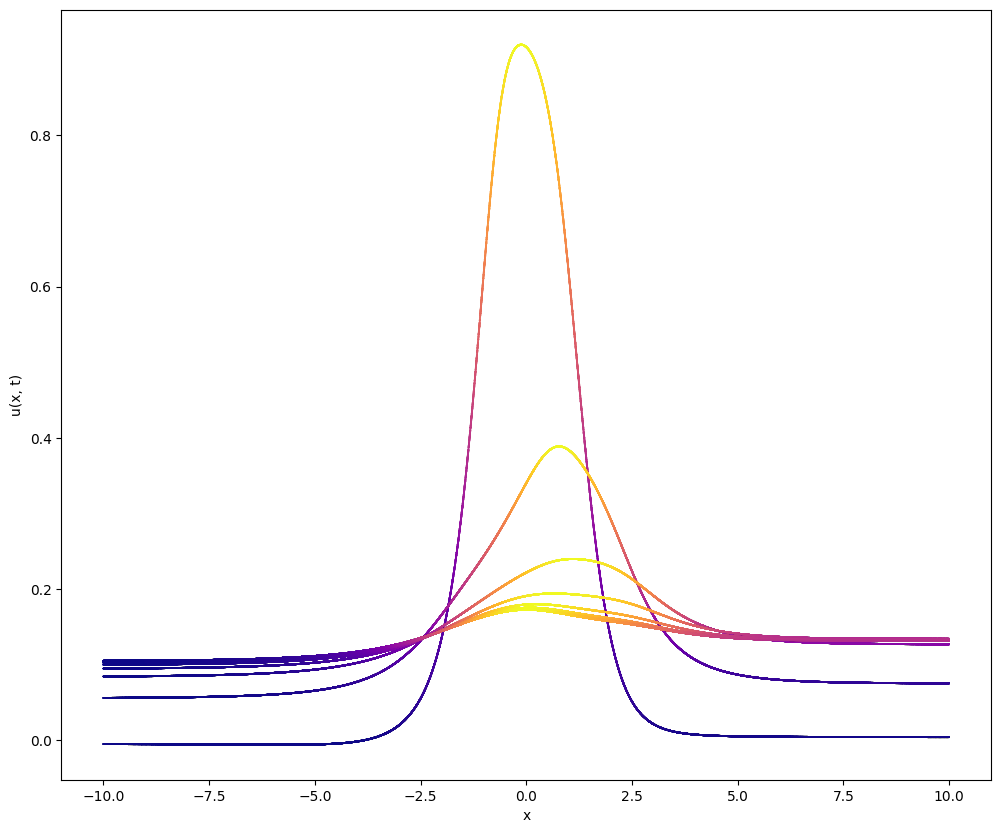

In [63]:
ax = plt.figure(figsize=(12, 10)).add_subplot()


for time_coef in torch.linspace(0, 5, 100):
    with torch.no_grad():
        u_sample = train_model.net(
            ModelInput(
                coords=Coords(x=x, y=None, z=None), 
                time=torch.ones(size=x.size()) * time_coef
            )
        ).logits

    ax.scatter(x, u_sample, s=0.1, alpha=0.9, c=u_sample, cmap="plasma")

ax.set_ylabel("u(x, t)")
ax.set_xlabel("x")

plt.show()

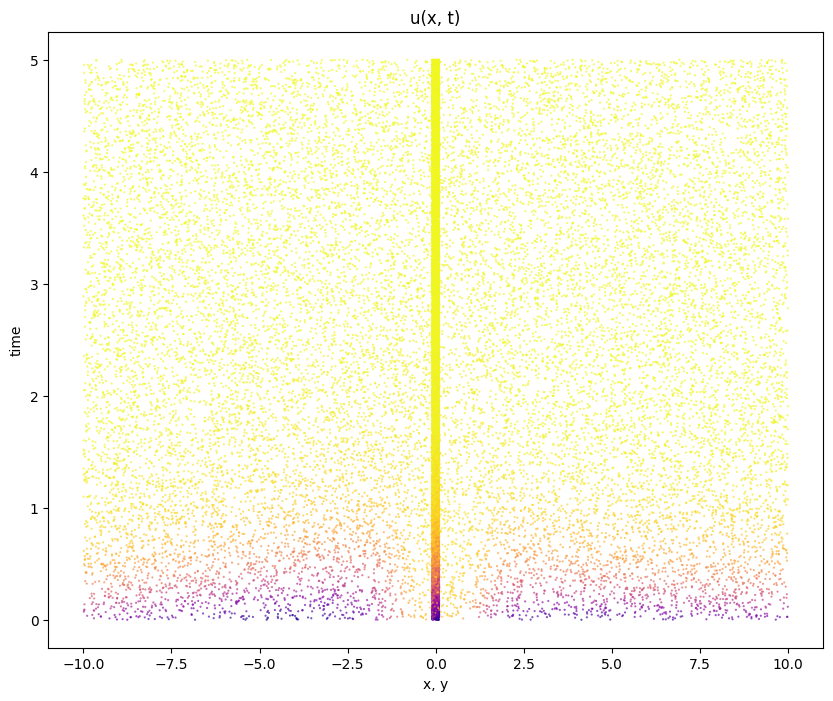

In [15]:
ax = plt.figure(figsize=(10, 8)).add_subplot()

ax.scatter(x, t, s=0.3, c=u, cmap="plasma", alpha=0.7)
ax.scatter(y, t, s=0.3, c=u, cmap="plasma", alpha=0.7)

ax.set_title("u(x, t)")
ax.set_ylabel("time")
ax.set_xlabel("x, y")

plt.show()

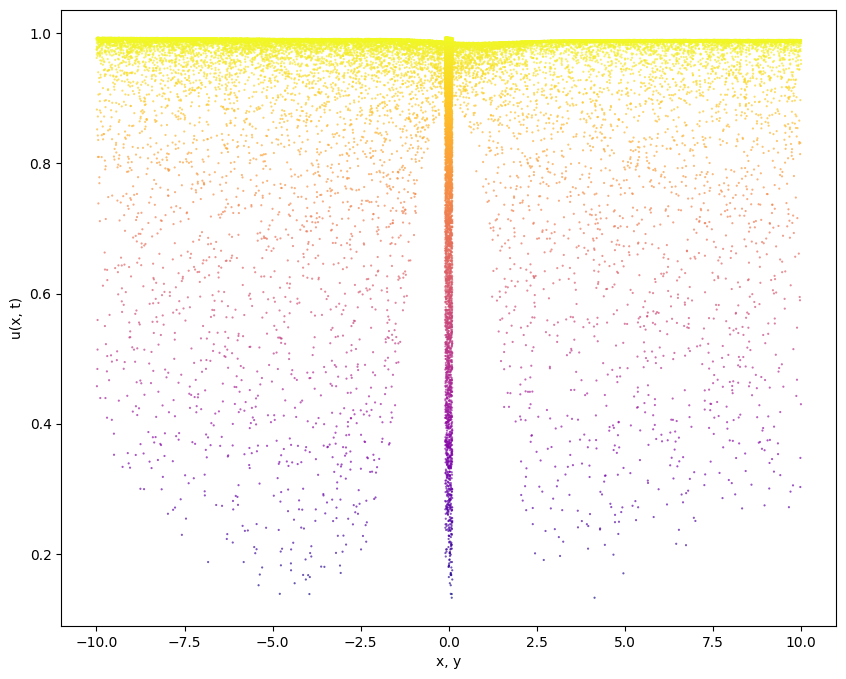

In [16]:
ax = plt.figure(figsize=(10, 8)).add_subplot()

ax.scatter(x, u, s=0.3, c=u, cmap="plasma", alpha=0.7)
ax.scatter(y, u, s=0.3, c=u, cmap="plasma", alpha=0.7)

ax.set_ylabel("u(x, t)")
ax.set_xlabel("x, y")

plt.show()

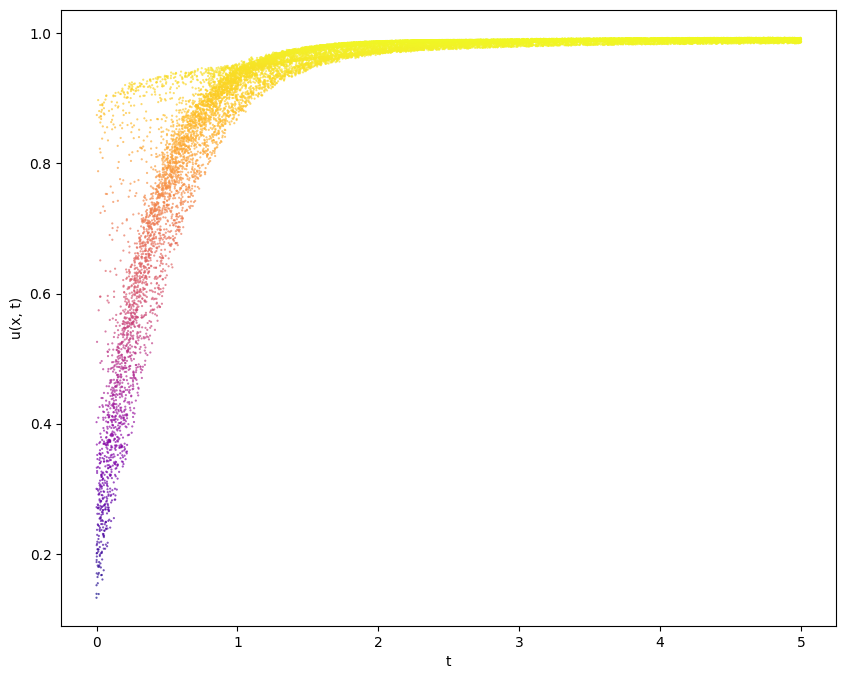

In [17]:
ax = plt.figure(figsize=(10, 8)).add_subplot()

ax.scatter(t, u, s=0.3, c=u, cmap="plasma", alpha=0.7)

ax.set_ylabel("u(x, t)")
ax.set_xlabel("t")

plt.show()

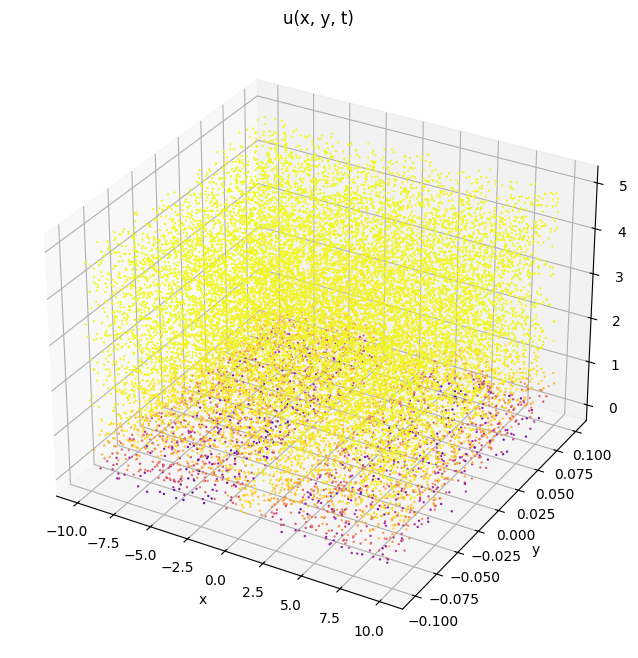

In [18]:
ax = plt.figure(figsize=(10, 8)).add_subplot(projection="3d")

ax.scatter(x, y, t, s=0.5, alpha=0.9, c=u, cmap="plasma")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("u(x, y, t)")

plt.show()

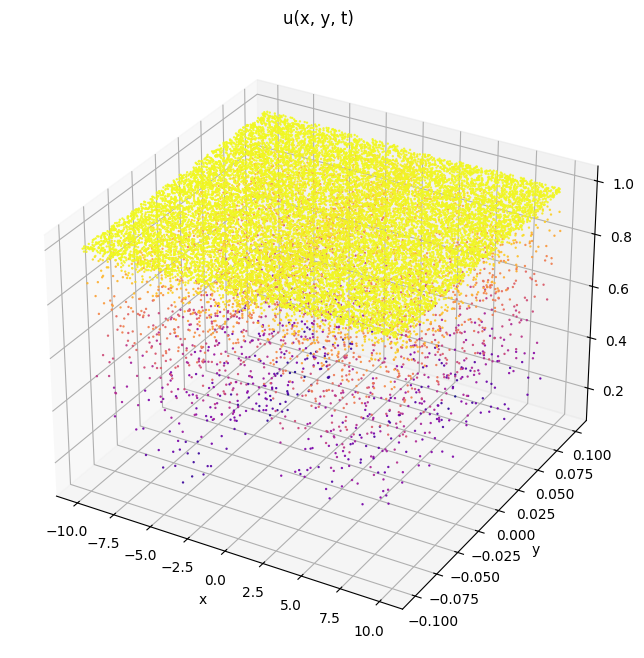

In [20]:
ax = plt.figure(figsize=(10, 8)).add_subplot(projection="3d")

ax.scatter(x, y, u, s=0.5, alpha=0.9, c=u, cmap="plasma")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("u(x, y, t)")

plt.show()

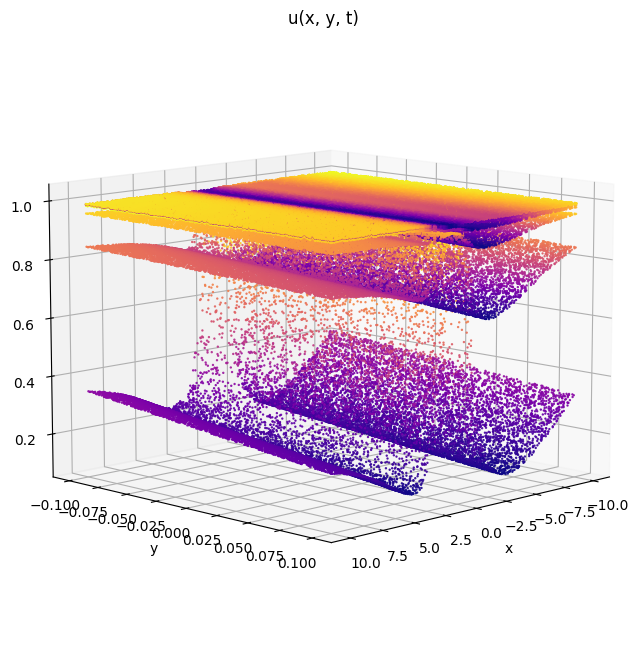

In [25]:
ax = plt.figure(figsize=(10, 8)).add_subplot(projection="3d")


for time_coef in torch.linspace(0, 5, 10):
    with torch.no_grad():
        u_sample = train_model.net(
            ModelInput(
                coords=Coords(x=x, y=y, z=None), 
                time=torch.ones(size=x.size()) * time_coef
            )
        ).logits

    ax.scatter(x, y, u_sample, s=0.5, alpha=0.9, c=u_sample, cmap="plasma")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("u(x, y, t)")

ax.view_init(10, 45)

plt.show()

In [28]:
dt = 1e-1 # Simulation timestep (s)

time = np.arange(0, 5, dt)


for time_coef in time:
    with torch.no_grad():
        u_sample = train_model.net(
            ModelInput(
                coords=Coords(x=x, y=y, z=None), 
                time=torch.ones(size=x.size()) * time_coef
            )
        ).logits

    
    fig = plt.figure(figsize=(8, 8), dpi=300)

    ax = fig.add_subplot(projection="3d")

    ax.set(xlim=[-10, 10], ylim=[-0.1, 0.1], zlim=[0, 1], xlabel="X", ylabel="Y", zlabel="u(X, Y, T)")

    ax.scatter(x, y, u_sample, s=0.5, alpha=0.9, c=u_sample, cmap="plasma")

    ax.view_init(10, 45)

    plt.savefig(f"pictures/solutions_gif/tmp_jpgs/burger_xyt_{round(time_coef, 2)}.jpeg", dpi=300, bbox_inches="tight")

    plt.close()

In [31]:
import glob

from PIL import Image


def make_gif(frame_folder):
    frames = [
        Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*"))
    ]
    frame_one = frames[0]
    frame_one.save(
        "pictures/solutions_gif/my_awesome.gif", format="GIF", append_images=frames, save_all=True, duration=15, loop=0
    )

In [32]:
make_gif("pictures/solutions_gif/tmp_jpgs")

In [33]:
!rm -r -f pictures/solutions_gif/tmp_jpgs/*